### questions from TJC
 - can we get estimates/error bars from wihtin individuals when it comes to dating admixture
 - can we get individual admixture ages per country (maybe a boxplot).
 - test for selection consider using the same ones from the previous paper and/or iHS.

# Ancestry *S.haematobium* vs. *S. bovis* across Africa (SCAN)

Neal Platt 2021

# Prep envrinoment and data for analyses

use the `sch_hae_scan/envs/jupyterlab_ancestry` conda environment

In [63]:
import os
import allel
import numpy as np
# import loter.locanc.local_ancestry as lc
import pandas as pd
# import vcf
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.pyplot import figure
from tqdm import tqdm
from pathlib import Path
from matplotlib.colors import ListedColormap
import scipy.stats as stats
import statsmodels.stats.multitest as smm

# from itertools import groupby
# import seaborn as sns
# import pickle
# from collections import Counter
# from IPython.display import Image 
# import dask.dataframe
# from dask.diagnostics import ProgressBar
# import glob
# from dask.distributed import Client
# import pybedtools
# import gffutils
# from scipy.signal import medfilt


In [2]:
proj_dir="/master/nplatt/sch_hae_scan"
results_dir=f"{proj_dir}/results"
os.chdir(results_dir)

## Get sample info

In [3]:
sample_info_df = pd.read_csv(f"{proj_dir}/data/seq_and_sample_docs/all_sh_sb_sample_data.csv")

In [4]:
sample_info_df

,admera_id,barcode_label_ID,library_id,sample_name,sra_accession,presumed_species,country,locale,host,phenotype,project,data_type,lat,lon
0,19047FL-14-02-03,MCF03050E0612,na,sha_angola_cota_57,SRR11907442,s_sp,angola,na,snail,unk,scan_africa,genome,-9.26186,16.13693
1,19047FL-14-02-04,MCF03050E0613,na,sha_angola_cota_58,SRR11907441,s_sp,angola,na,snail,unk,scan_africa,genome,-9.26186,16.13693
2,19047FL-14-02-05,MCF03050E0614,na,sha_angola_cota_59,SRR11907440,s_sp,angola,na,snail,unk,scan_africa,genome,-9.26186,16.13693
3,19047FL-14-02-06,MCF03050E0615,na,sha_angola_icau_60,SRR11907439,s_haematobium,angola,na,human,haematobium,scan_africa,genome,-8.64510,13.79642
4,19047FL-14-02-07,MCF03050E0615,na,sha_angola_icau_61,SRR11907438,s_haematobium,angola,na,human,haematobium,scan_africa,genome,-8.64510,13.79642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,na,na,na,sh_egypt_SRR433862,SRR433862,s_haematobium,egypt,na,na,haematobium,Rey_2019,genome,NaN,NaN
445,na,na,na,sh_gambia_SRR13579872,SRR13579872,s_haematobium,gambia,na,na,haematobium,Rey_2019,genome,NaN,NaN
446,na,na,na,sh_ivorycoast_SRR13579866,SRR13579866,s_haematobium,ivorycoast,na,na,haematobium,Rey_2019,genome,NaN,NaN
447,na,na,na,sh_madagascar_SRR13579871,SRR13579871,s_haematobium,madagascar,na,na,haematobium,Rey_2019,genome,NaN,NaN


## Read in data and get allele counts

In [5]:
#read in the vcf file
filtered_callset=allel.read_vcf('post_phase_filtering/chrs_unrelated.vcf')

In [6]:
#get relevant info
gt      = allel.GenotypeArray(filtered_callset['calldata/GT'])
chroms  = filtered_callset["variants/CHROM"]
samples = filtered_callset["samples"]
poss    = filtered_callset["variants/POS"]
var_ids = filtered_callset["variants/ID"]

uniq_chroms=np.unique(chroms)

In [7]:
#read in pca df since it has species ids and kmeans labels
pca_df=pd.read_csv("{}/pca/pca_df.csv".format(results_dir), sep=",")
pca_df["country"] = pca_df["country"].astype(str)

### Species

In [8]:
#get species idxs
sp_idxs = {}
sp_acs  = {}

for sp in tqdm(["s_bovis", "s_haematobium"]):
    
    #find indecies for each sample from that species
    names = pca_df.loc[pca_df["pca_species"] ==  sp, "sample_name"]
    sp_idxs[sp]=np.in1d(samples, names).nonzero()[0]

    #get allele counts for each species
    sp_acs[sp] = gt.count_alleles(subpop=sp_idxs[sp])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:35<00:00, 17.77s/it]


In [9]:
#add outgroups
s_guineensis   = "guineensis_saotome_ERR119612"
s_intercalatum = "intercalatum_drcongo_ERR119613"
s_margrebowiei = "margrebowiei_zambia_ERR310940"
s_matthei      = "matthei_zambia_ERR103051"

outgroups=[s_guineensis, s_intercalatum, s_margrebowiei, s_matthei]


In [10]:
for sp in tqdm(outgroups):
    sp_idxs[sp] = [list(samples).index(sp)]
    sp_acs[sp] = gt.count_alleles(subpop=sp_idxs[sp])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:15<00:00,  3.84s/it]


### Kmeans group

In [11]:
#get species idxs
k_pop_idxs = {}
k_pop_acs  = {}

for k in tqdm(pca_df["kmeans_label"].unique()):
    
    #find indecies for each sample per k population
    ks = pca_df.loc[pca_df["kmeans_label"] ==  k, "sample_name"]
    k_pop_idxs[k]=np.in1d(samples, ks).nonzero()[0]
    
    #get allele counts for k group
    k_pop_acs[k] = gt.count_alleles(subpop=k_pop_idxs[k])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:41<00:00,  5.99s/it]


In [12]:
major_acs={"sh_nw":  k_pop_acs["sh_nw"],
           "sh_se": k_pop_acs["sh_se"],
           "sb":    k_pop_acs["sb"] ,
           "sh":    sp_acs["s_haematobium"],
           "s_guineensis":   sp_acs["guineensis_saotome_ERR119612"],
           "s_intercalatum": sp_acs["intercalatum_drcongo_ERR119613"],
           "s_margrebowiei": sp_acs["margrebowiei_zambia_ERR310940"],
           "s_matthei":      sp_acs["matthei_zambia_ERR103051"]  }

# Pi and Tajima's D

In [13]:
Path("{}/summary_stats".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/summary_stats".format(results_dir))

In [14]:
window_kb_size = 10

In [20]:
stat_dfs=defaultdict(lambda: pd.DataFrame(columns=["pi", "tajimas_d", "start", "stop", "n_bases", "n_snps", "chrom"]))

major_chroms=uniq_chroms[0:8]
pops=["sh", "sh_nw", "sh_se", "sb"]

for pop in pops:
    for chrom in tqdm(major_chroms):
        chrom_pos = poss[chroms == chrom]
        chrom_ac =  major_acs[pop][chroms == chrom]
        
        if len(chrom_ac) > 10:

            try:
                pi, windows, nbases, counts = allel.windowed_diversity(chrom_pos, chrom_ac, window_kb_size*1_000)
                td, windows, counts =  allel.windowed_tajima_d(chrom_pos, chrom_ac, size=window_kb_size*1_000)

                #add info to a df
                chr_df=pd.DataFrame([pi, td, windows[:,0], windows[:,1], nbases, counts]).T
                chr_df.columns=["pi", "tajimas_d", "start", "stop", "n_bases", "n_snps"]
                chr_df["chrom"]=chrom

                stat_dfs[pop]=pd.concat([stat_dfs[pop], chr_df])

            except:
                print("An exception occurred: {}:{}".format(pop, chrom))
                break

        #reset index
        stat_dfs[pop]=stat_dfs[pop].reset_index(drop=True)

        #save df to a csv
        stat_dfs[pop].to_csv(f"summary_stats_{window_kb_size}kb_windows_{pop}.csv", index=False, sep=",")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:18<00:00,  2.30s/it]


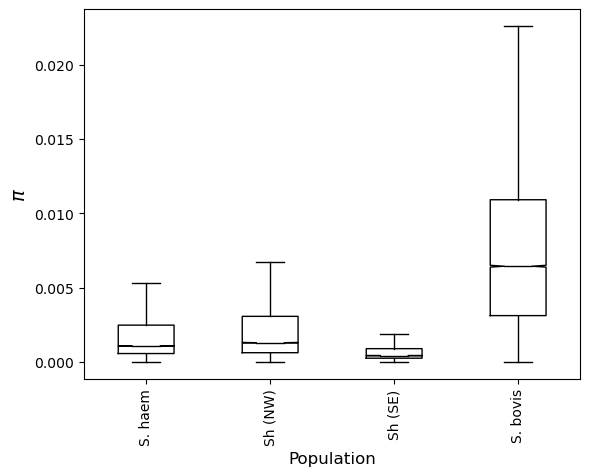

In [21]:
plt.boxplot([ stat_dfs["sh"].dropna(subset=["pi"])["pi"],
              stat_dfs["sh_nw"].dropna(subset=["pi"])["pi"],
              stat_dfs["sh_se"].dropna(subset=["pi"])["pi"],
              stat_dfs["sb"].dropna(subset=["pi"])["pi"]    ],
            
             showfliers=False, 
             notch=True,
             labels=["S. haem", "Sh (NW)", "Sh (SE)", "S. bovis" ],

             medianprops=dict(color="black", lw=1))

plt.xticks(rotation=90)
plt.xlabel("Population", fontsize=12)
plt.ylabel("$\pi$", fontsize=14)
plt.savefig("pi_boxplot_{}kb_windows.svg".format(window_kb_size))
plt.savefig("pi_boxplot_{}kb_windows.png".format(window_kb_size), dpi=300)
plt.show()


In [22]:
print(f"pop\tmean_pi\tstdev")
for pop in stat_dfs.keys():
    mean_pi = stat_dfs[pop].dropna(subset=["pi"])["pi"].mean()
    std = stat_dfs[pop].dropna(subset=["pi"])["pi"].std()
    print(f"{pop}\t{mean_pi}\t{std}")

pop	mean_pi	stdev
sh	0.00222836533131809	0.002949546453315629
sh_nw	0.0025703585831520176	0.00322878064610488
sh_se	0.001258239211290319	0.002299031817812884
sb	0.007325846533614187	0.005148333899710463


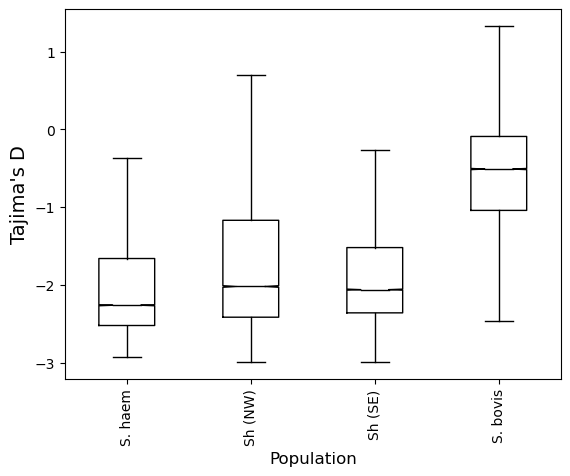

In [23]:
plt.boxplot([ stat_dfs["sh"].dropna(subset=["tajimas_d"])["tajimas_d"],
              stat_dfs["sh_nw"].dropna(subset=["tajimas_d"])["tajimas_d"],
              stat_dfs["sh_se"].dropna(subset=["tajimas_d"])["tajimas_d"],
              stat_dfs["sb"].dropna(subset=["tajimas_d"])["tajimas_d"]    ],
            
             showfliers=False, 
             notch=True,
             labels=["S. haem", "Sh (NW)", "Sh (SE)", "S. bovis" ],

             medianprops=dict(color="black", lw=1))

plt.xticks(rotation=90)
plt.xlabel("Population", fontsize=12)
plt.ylabel("Tajima's D", fontsize=14)
plt.savefig("td_boxplot_{}kb_windows.svg".format(window_kb_size))
plt.savefig("td_boxplot_{}kb_windows.png".format(window_kb_size), dpi=300)
plt.show()

In [25]:
print(f"pop\tmean_tajima's_d\tstdev")
for pop in stat_dfs.keys():
    mean_td = stat_dfs[pop].dropna(subset=["tajimas_d"])["tajimas_d"].mean()
    std = stat_dfs[pop].dropna(subset=["tajimas_d"])["tajimas_d"].std()
    print(f"{pop}\t{mean_td}\t{std}")

pop	mean_tajima's_d	stdev
sh	-1.9085320948076043	0.9384305454513059
sh_nw	-1.6330942442380194	1.0881515125279926
sh_se	-1.6730205754653114	1.1511504117065587
sb	-0.5656047709102896	0.7310227810760503


In [29]:
stat_dfs["sh_nw"]

,pi,tajimas_d,start,stop,n_bases,n_snps,chrom
0,0.001046,-1.066640,14416.0,24415.0,10000.0,147.0,NC_067195.1
1,0.000743,-1.575858,24416.0,34415.0,10000.0,177.0,NC_067195.1
2,0.000403,-1.475178,34416.0,44415.0,10000.0,80.0,NC_067195.1
3,0.000000,NaN,44416.0,54415.0,10000.0,0.0,NC_067195.1
4,0.000043,-1.000305,54416.0,64415.0,10000.0,11.0,NC_067195.1
...,...,...,...,...,...,...,...
39187,0.002784,-0.154628,19430276.0,19440275.0,10000.0,516.0,NC_067202.1
39188,0.000653,-0.585316,19440276.0,19450275.0,10000.0,118.0,NC_067202.1
39189,0.007115,0.071655,19450276.0,19460275.0,10000.0,665.0,NC_067202.1
39190,0.011202,-0.456642,19460276.0,19470275.0,10000.0,1403.0,NC_067202.1


In [30]:
stat_dfs["sh_se"]

,pi,tajimas_d,start,stop,n_bases,n_snps,chrom
0,0.000977,0.205585,14416.0,24415.0,10000.0,147.0,NC_067195.1
1,0.000381,-1.697061,24416.0,34415.0,10000.0,177.0,NC_067195.1
2,0.000369,-0.874169,34416.0,44415.0,10000.0,80.0,NC_067195.1
3,0.000000,NaN,44416.0,54415.0,10000.0,0.0,NC_067195.1
4,0.000060,0.135164,54416.0,64415.0,10000.0,11.0,NC_067195.1
...,...,...,...,...,...,...,...
39187,0.002791,0.316147,19430276.0,19440275.0,10000.0,516.0,NC_067202.1
39188,0.000644,-0.675211,19440276.0,19450275.0,10000.0,118.0,NC_067202.1
39189,0.006323,1.183424,19450276.0,19460275.0,10000.0,665.0,NC_067202.1
39190,0.011685,0.466402,19460276.0,19470275.0,10000.0,1403.0,NC_067202.1


# Pi across the genome

In [121]:
uniq_chroms= ["NC_067196.1", "NC_067197.1", "NC_067198.1", "NC_067199.1", "NC_067200.1", "NC_067201.1", "NC_067202.1"]


In [122]:
pi_df = stat_dfs["sh_se"][["chrom", "start", "stop", "n_snps", "pi"]]
pi_df=pi_df.rename(columns={"pi":     "se_pi"})

pi_df["sb_pi"] = stat_dfs["sh_nw"]["pi"]
pi_df["nw_pi"] = stat_dfs["sb"]["pi"]
pi_df["sh_pi"] = stat_dfs["sh"]["pi"]

pi_df

,chrom,start,stop,n_snps,se_pi,sb_pi,nw_pi,sh_pi
0,NC_067195.1,14416.0,24415.0,147.0,0.000977,0.001046,0.001125,0.001077
1,NC_067195.1,24416.0,34415.0,177.0,0.000381,0.000743,0.001331,0.000608
2,NC_067195.1,34416.0,44415.0,80.0,0.000369,0.000403,0.001181,0.000399
3,NC_067195.1,44416.0,54415.0,0.0,0.000000,0.000000,0.000000,0.000000
4,NC_067195.1,54416.0,64415.0,11.0,0.000060,0.000043,0.000227,0.000051
...,...,...,...,...,...,...,...,...
39187,NC_067202.1,19430276.0,19440275.0,516.0,0.002791,0.002784,0.003523,0.002834
39188,NC_067202.1,19440276.0,19450275.0,118.0,0.000644,0.000653,0.000992,0.000661
39189,NC_067202.1,19450276.0,19460275.0,665.0,0.006323,0.007115,0.007038,0.006875
39190,NC_067202.1,19460276.0,19470275.0,1403.0,0.011685,0.011202,0.014330,0.011634


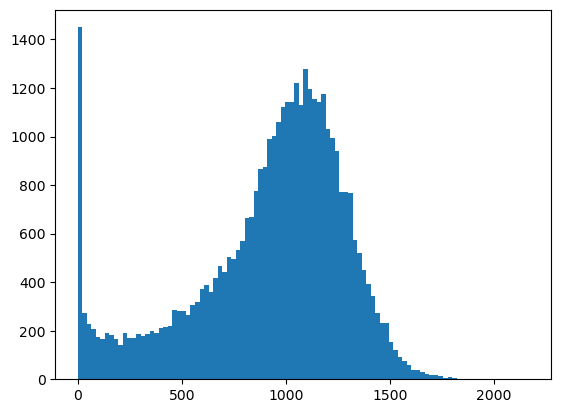

In [123]:
plt.hist(pi_df["n_snps"], bins=100)
plt.show()

In [125]:
pi_df = pi_df.loc[pi_df["n_snps"] > 50]

In [126]:
# Calculate the genomic position for each data point
chrom_lengths = pi_df.groupby("chrom")["stop"].max() - 1

chrom_offsets = chrom_lengths.cumsum().shift(1).fillna(0)
pi_df["genomic_position"] = pi_df["chrom"].map(chrom_offsets).astype(int) + pi_df["start"]
pi_df=pi_df.sort_values("genomic_position").reset_index(drop=True)
pi_df

/tmp/ipykernel_200208/2776085754.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pi_df["genomic_position"] = pi_df["chrom"].map(chrom_offsets).astype(int) + pi_df["start"]


,chrom,start,stop,n_snps,se_pi,sb_pi,nw_pi,sh_pi,genomic_position
0,NC_067195.1,14416.0,24415.0,147.0,0.000977,0.001046,0.001125,0.001077,14416.0
1,NC_067195.1,24416.0,34415.0,177.0,0.000381,0.000743,0.001331,0.000608,24416.0
2,NC_067195.1,34416.0,44415.0,80.0,0.000369,0.000403,0.001181,0.000399,34416.0
3,NC_067195.1,64416.0,74415.0,137.0,0.000750,0.000521,0.001459,0.000774,64416.0
4,NC_067195.1,84416.0,94415.0,329.0,0.001537,0.000968,0.005066,0.001411,84416.0
...,...,...,...,...,...,...,...,...,...
37382,NC_067202.1,19430276.0,19440275.0,516.0,0.002791,0.002784,0.003523,0.002834,392008040.0
37383,NC_067202.1,19440276.0,19450275.0,118.0,0.000644,0.000653,0.000992,0.000661,392018040.0
37384,NC_067202.1,19450276.0,19460275.0,665.0,0.006323,0.007115,0.007038,0.006875,392028040.0
37385,NC_067202.1,19460276.0,19470275.0,1403.0,0.011685,0.011202,0.014330,0.011634,392038040.0


In [127]:
ratio = np.log10(pi_df["nw_pi"]/pi_df["se_pi"])
pi_df["pi_ratio_nw_se"]=ratio
#plt.scatter(x=pi_df["genomic_position"], y=pi_df["pi_ratio_nw_se"])


/master/nplatt/anaconda3/envs/ancestry/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


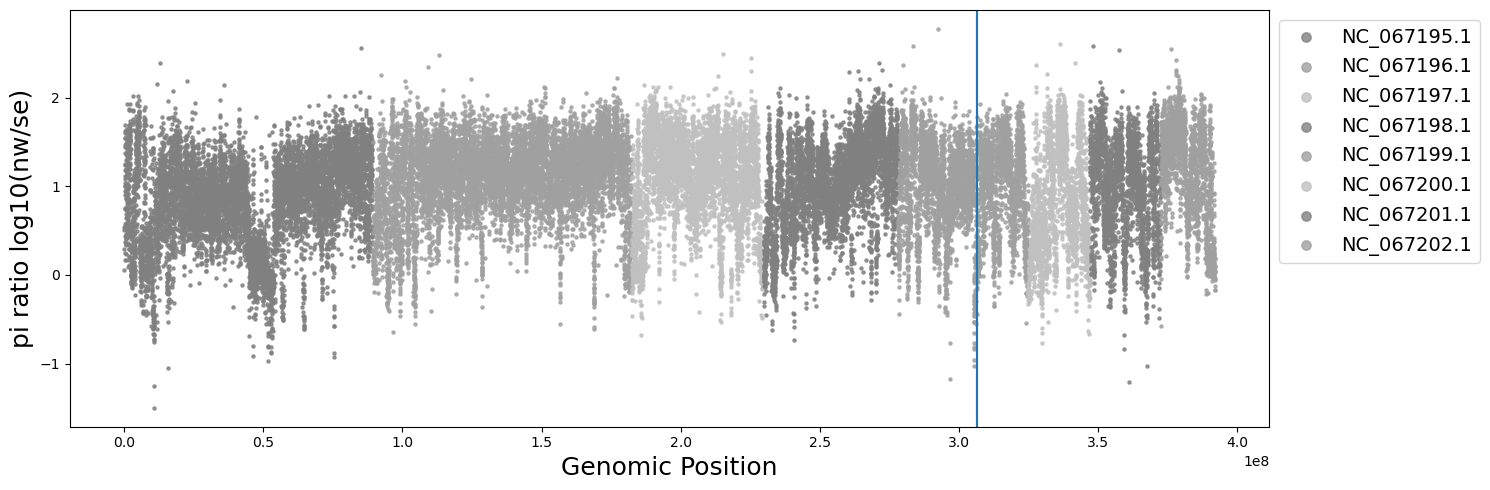

In [128]:
# Create the Manhattan plot figure and axis
fig, ax = plt.subplots(figsize=(15, 5))

# Define three shades of grey
shades_of_grey = ['#808080', '#A0A0A0', '#C0C0C0']

# Create the colormap
custom_cmap = ListedColormap(shades_of_grey)

#plot position of the invadolysin locus
#plot position of the invadolysin locus
plt.axvline(x=chrom_offsets["NC_067199.1"] + 28495140, ymin=-3, ymax=3)
plt.axvline(x=chrom_offsets["NC_067199.1"] + 28467137, ymin=-3, ymax=3)

# Iterate through the groups of chromosomes and plot each group with a different color

for i, (chrom, group) in enumerate(pi_df.groupby("chrom")):
    color = custom_cmap(i % custom_cmap.N)  # Get a color from the colormap
    ax.scatter(group["genomic_position"], group["pi_ratio_nw_se"], s=5, alpha=0.8, color=color, label=f'{chrom}')

# # Plot the significant data points (Bonferroni corrected) in red
# ax.scatter(sig_bonf["genomic_position"], sig_bonf["xpehh"], s=10, alpha=1, color='red', label='Sig.')

# Set the x-axis and y-axis labels
ax.set_xlabel("Genomic Position", fontsize=18)
ax.set_ylabel("pi ratio log10(nw/se)", fontsize=18)

# Add the legend outside the plot in the upper right corner
ax.legend(markerscale=3, fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

# Adjust the layout to fit the plot in the figure
plt.tight_layout()

# Show the plot
plt.show()

# Save the plot as an SVG file
fig.savefig('nw_vs_se_pi_ratio.svg', format='svg')

# Save the plot as a 300 dpi PNG file
fig.savefig('nw_vs_se_pi_ratio.png', dpi=300, format='png')


In [129]:
invad_start = chrom_offsets["NC_067199.1"] + 28467137
invad_stop  = chrom_offsets["NC_067199.1"] + 28495140

In [130]:
ch4_df = pi_df.loc[pi_df["chrom"] == "NC_067199.1"]

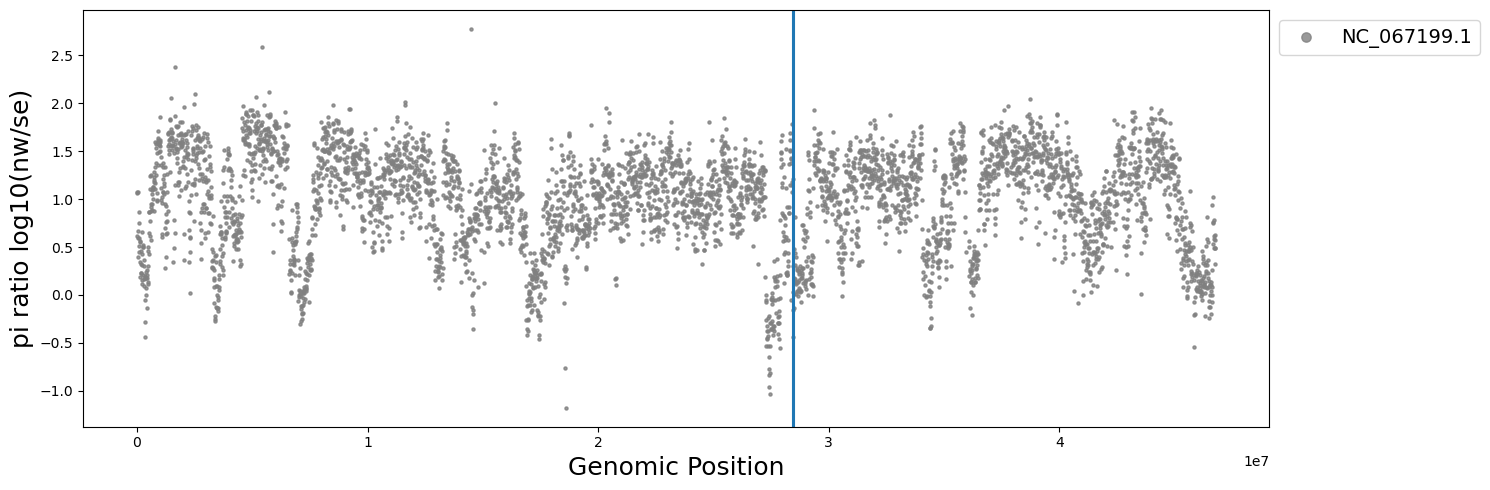

In [131]:
# Create the Manhattan plot figure and axis
fig, ax = plt.subplots(figsize=(15, 5))

# Define three shades of grey
shades_of_grey = ['#808080', '#A0A0A0', '#C0C0C0']

# Create the colormap
custom_cmap = ListedColormap(shades_of_grey)

#plot position of the invadolysin locus
plt.axvline(x=28495140, ymin=-3, ymax=3)
plt.axvline(x=28467137, ymin=-3, ymax=3)

# Iterate through the groups of chromosomes and plot each group with a different color

for i, (chrom, group) in enumerate(ch4_df.groupby("chrom")):
    color = custom_cmap(i % custom_cmap.N)  # Get a color from the colormap
    ax.scatter(group["start"], group["pi_ratio_nw_se"], s=5, alpha=0.8, color=color, label=f'{chrom}')

# # Plot the significant data points (Bonferroni corrected) in red

# Set the x-axis and y-axis labels
ax.set_xlabel("Genomic Position", fontsize=18)
ax.set_ylabel("pi ratio log10(nw/se)", fontsize=18)

# Add the legend outside the plot in the upper right corner
ax.legend(markerscale=3, fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

# Adjust the layout to fit the plot in the figure
plt.tight_layout()

# Show the plot
plt.show()

# Save the plot as an SVG file
fig.savefig('nw_vs_se_pi_ratio_peak.svg', format='svg')

# Save the plot as a 300 dpi PNG file
fig.savefig('nw_vs_se_pi_ratio_peak.png', dpi=300, format='png')


In [132]:
pi_df.to_csv("pi_df.csv", sep=",", header=True, index=False)

In [133]:
pi_df=pd.read_csv("pi_df.csv", sep=",")
pi_df=pi_df.dropna(subset=["pi_ratio_nw_se"])
pi_df = pi_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['pi_ratio_nw_se'])
z_scores = stats.zscore(pi_df["pi_ratio_nw_se"])
pi_df["ratio_z_scores"] = z_scores
pi_df

,chrom,start,stop,n_snps,se_pi,sb_pi,nw_pi,sh_pi,genomic_position,pi_ratio_nw_se,ratio_z_scores
0,NC_067195.1,14416.0,24415.0,147.0,0.000977,0.001046,0.001125,0.001077,14416.0,0.060928,-1.842294
1,NC_067195.1,24416.0,34415.0,177.0,0.000381,0.000743,0.001331,0.000608,24416.0,0.543247,-0.892011
2,NC_067195.1,34416.0,44415.0,80.0,0.000369,0.000403,0.001181,0.000399,34416.0,0.504884,-0.967596
3,NC_067195.1,64416.0,74415.0,137.0,0.000750,0.000521,0.001459,0.000774,64416.0,0.288882,-1.393170
4,NC_067195.1,84416.0,94415.0,329.0,0.001537,0.000968,0.005066,0.001411,84416.0,0.517843,-0.942063
...,...,...,...,...,...,...,...,...,...,...,...
37382,NC_067202.1,19430276.0,19440275.0,516.0,0.002791,0.002784,0.003523,0.002834,392008040.0,0.101210,-1.762927
37383,NC_067202.1,19440276.0,19450275.0,118.0,0.000644,0.000653,0.000992,0.000661,392018040.0,0.188022,-1.591888
37384,NC_067202.1,19450276.0,19460275.0,665.0,0.006323,0.007115,0.007038,0.006875,392028040.0,0.046546,-1.870628
37385,NC_067202.1,19460276.0,19470275.0,1403.0,0.011685,0.011202,0.014330,0.011634,392038040.0,0.088616,-1.787741


In [134]:
p_values = stats.norm.sf(np.abs(pi_df["ratio_z_scores"])) * 2  # Two-tailed p-values
pi_df["p_value"] = p_values

pi_df

,chrom,start,stop,n_snps,se_pi,sb_pi,nw_pi,sh_pi,genomic_position,pi_ratio_nw_se,ratio_z_scores,p_value
0,NC_067195.1,14416.0,24415.0,147.0,0.000977,0.001046,0.001125,0.001077,14416.0,0.060928,-1.842294,0.065432
1,NC_067195.1,24416.0,34415.0,177.0,0.000381,0.000743,0.001331,0.000608,24416.0,0.543247,-0.892011,0.372387
2,NC_067195.1,34416.0,44415.0,80.0,0.000369,0.000403,0.001181,0.000399,34416.0,0.504884,-0.967596,0.333246
3,NC_067195.1,64416.0,74415.0,137.0,0.000750,0.000521,0.001459,0.000774,64416.0,0.288882,-1.393170,0.163569
4,NC_067195.1,84416.0,94415.0,329.0,0.001537,0.000968,0.005066,0.001411,84416.0,0.517843,-0.942063,0.346160
...,...,...,...,...,...,...,...,...,...,...,...,...
37382,NC_067202.1,19430276.0,19440275.0,516.0,0.002791,0.002784,0.003523,0.002834,392008040.0,0.101210,-1.762927,0.077913
37383,NC_067202.1,19440276.0,19450275.0,118.0,0.000644,0.000653,0.000992,0.000661,392018040.0,0.188022,-1.591888,0.111410
37384,NC_067202.1,19450276.0,19460275.0,665.0,0.006323,0.007115,0.007038,0.006875,392028040.0,0.046546,-1.870628,0.061397
37385,NC_067202.1,19460276.0,19470275.0,1403.0,0.011685,0.011202,0.014330,0.011634,392038040.0,0.088616,-1.787741,0.073818


In [135]:
# Bonferroni correction
_, p_values_bonferroni, _, _ = smm.multipletests(pi_df["p_value"], method='bonferroni')
pi_df["p_value_bonferroni"] = p_values_bonferroni

# Benjamini-Hochberg correction (False Discovery Rate)
_, fdr, _, _ = smm.multipletests(pi_df["p_value"], method='fdr_bh')
pi_df["fdr"] = fdr


alpha = 0.05
sig_bonf = pi_df[pi_df["p_value_bonferroni"] < alpha]
sig_fdr = pi_df[pi_df["fdr"] < alpha]

In [136]:
sig_bonf

,chrom,start,stop,n_snps,se_pi,sb_pi,nw_pi,sh_pi,genomic_position,pi_ratio_nw_se,ratio_z_scores,p_value,p_value_bonferroni,fdr
991,NC_067195.1,10604416.0,10614415.0,851.0,0.015942,0.010408,0.000505,0.013004,10604416.0,-1.49916,-4.916033,8.831562e-07,0.033011,0.033011


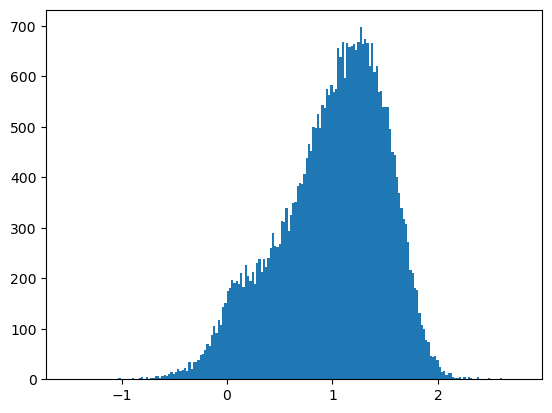

In [137]:
plt.hist(pi_df["pi_ratio_nw_se"], bins=200)
plt.show()

In [138]:
pi_df["ratio_percentile"] = pi_df["pi_ratio_nw_se"].rank(pct=True)

In [139]:
pi_df

,chrom,start,stop,n_snps,se_pi,sb_pi,nw_pi,sh_pi,genomic_position,pi_ratio_nw_se,ratio_z_scores,p_value,p_value_bonferroni,fdr,ratio_percentile
0,NC_067195.1,14416.0,24415.0,147.0,0.000977,0.001046,0.001125,0.001077,14416.0,0.060928,-1.842294,0.065432,1.0,0.960952,0.053962
1,NC_067195.1,24416.0,34415.0,177.0,0.000381,0.000743,0.001331,0.000608,24416.0,0.543247,-0.892011,0.372387,1.0,0.960952,0.193081
2,NC_067195.1,34416.0,44415.0,80.0,0.000369,0.000403,0.001181,0.000399,34416.0,0.504884,-0.967596,0.333246,1.0,0.960952,0.178367
3,NC_067195.1,64416.0,74415.0,137.0,0.000750,0.000521,0.001459,0.000774,64416.0,0.288882,-1.393170,0.163569,1.0,0.960952,0.111135
4,NC_067195.1,84416.0,94415.0,329.0,0.001537,0.000968,0.005066,0.001411,84416.0,0.517843,-0.942063,0.346160,1.0,0.960952,0.183423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37382,NC_067202.1,19430276.0,19440275.0,516.0,0.002791,0.002784,0.003523,0.002834,392008040.0,0.101210,-1.762927,0.077913,1.0,0.960952,0.063674
37383,NC_067202.1,19440276.0,19450275.0,118.0,0.000644,0.000653,0.000992,0.000661,392018040.0,0.188022,-1.591888,0.111410,1.0,0.960952,0.085692
37384,NC_067202.1,19450276.0,19460275.0,665.0,0.006323,0.007115,0.007038,0.006875,392028040.0,0.046546,-1.870628,0.061397,1.0,0.960952,0.050457
37385,NC_067202.1,19460276.0,19470275.0,1403.0,0.011685,0.011202,0.014330,0.011634,392038040.0,0.088616,-1.787741,0.073818,1.0,0.960952,0.060330
